# Multicollinearity detection

### A dataset quality check step for Machine Learning training.

We will be looking at:

- Matrix Multiplication Determinant (should not be close to zero)
- Variance Inflaction Factor (should be < 5)
- Pearson's Correlation (ideally shouldn't be > 5)
- Condition number $\kappa$ (should be small)
- Singular Values (should have low variance)

## Preparation

In [302]:
import pandas as pd
import seaborn as sns
import numpy as np

### Example [dataset](https://www.kaggle.com/geoffnel/evs-one-electric-vehicle-dataset)

In [303]:
df = pd.read_csv('ElectricCarData_Clean.csv')
df

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Nissan,Ariya 63kWh,7.5,160,330,191,440,Yes,FWD,Type 2 CCS,Hatchback,C,5,45000
99,Audi,e-tron S Sportback 55 quattro,4.5,210,335,258,540,Yes,AWD,Type 2 CCS,SUV,E,5,96050
100,Nissan,Ariya e-4ORCE 63kWh,5.9,200,325,194,440,Yes,AWD,Type 2 CCS,Hatchback,C,5,50000
101,Nissan,Ariya e-4ORCE 87kWh Performance,5.1,200,375,232,450,Yes,AWD,Type 2 CCS,Hatchback,C,5,65000


Small correction for missing values

In [304]:
df.FastCharge_KmH = df.FastCharge_KmH.replace('-', 0).astype(int)
df.FastCharge_KmH = df.FastCharge_KmH.replace(0, df.FastCharge_KmH.mean())

For simplification, limiting set to numeric variables

In [305]:
data = df.loc[:, df.columns.isin(df.corr().columns)]
data

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Seats,PriceEuro
0,4.6,233,450,161,940.0,5,55480
1,10.0,160,270,167,250.0,5,30000
2,4.7,210,400,181,620.0,5,56440
3,6.8,180,360,206,560.0,5,68040
4,9.5,145,170,168,190.0,4,32997
...,...,...,...,...,...,...,...
98,7.5,160,330,191,440.0,5,45000
99,4.5,210,335,258,540.0,5,96050
100,5.9,200,325,194,440.0,5,50000
101,5.1,200,375,232,450.0,5,65000


And normalize

In [306]:
data = data.apply(lambda x: x/x.max())

## Correlation (Pearson's)

Many of them are very high. Problem alert!

<AxesSubplot:>

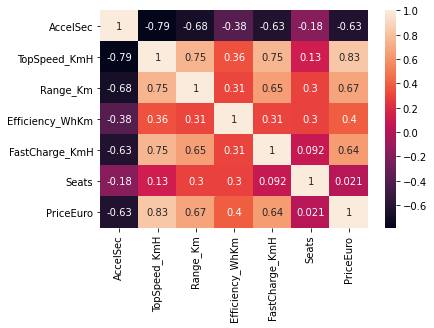

In [307]:
sns.heatmap(data.corr(), annot=True)

## Variance Inflation Factor

Checking for multicollinearity. VIF > 5 is usually bad.

In [308]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data['Feature'] = data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
vif_data

,Feature,VIF
0,AccelSec,8.238046
1,TopSpeed_KmH,68.106085
2,Range_Km,23.788942
3,Efficiency_WhKm,46.226969
4,FastCharge_KmH,15.561937
5,Seats,48.265071
6,PriceEuro,12.444911


## Linear Algebra

The matrix $X^TX$, where $X$ is our dataset, tells us important things about our data.

In [309]:
data_mul = data.T @ data # X^TX
print(data_mul.shape)
data_mul

(7, 7)


,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Seats,PriceEuro
AccelSec,13.080078,13.715875,10.669551,22.995405,14.679944,23.452168,7.460180
TopSpeed_KmH,13.715875,20.827156,16.774353,31.610453,23.521844,31.561672,13.112763
Range_Km,10.669551,16.774353,14.285976,25.376289,19.232394,25.549337,10.758242
Efficiency_WhKm,22.995405,31.610453,25.376289,50.649546,35.304777,50.169021,19.222606
FastCharge_KmH,14.679944,23.521844,19.232394,35.304777,28.651908,35.054342,15.135409
Seats,23.452168,31.561672,25.549337,50.169021,35.054342,51.448980,18.691815
PriceEuro,7.460180,13.112763,10.758242,19.222606,15.135409,18.691815,9.511860


### Singular Value Decomposition (SVD)

Normalization (again) is required for the condition number

In [310]:
data_mul = data_mul.apply(lambda x: x/x.max())
data_mul

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Seats,PriceEuro
AccelSec,0.557734,0.433903,0.417606,0.454010,0.415806,0.455833,0.388094
TopSpeed_KmH,0.584845,0.658869,0.656547,0.624101,0.666251,0.613456,0.682153
Range_Km,0.454949,0.530658,0.559153,0.501017,0.544753,0.496596,0.559666
Efficiency_WhKm,0.980524,1.000000,0.993227,1.000000,1.000000,0.975122,1.000000
FastCharge_KmH,0.625953,0.744116,0.752755,0.697040,0.811559,0.681342,0.787376
Seats,1.000000,0.998457,1.000000,0.990513,0.992906,1.000000,0.972387
PriceEuro,0.318102,0.414824,0.421077,0.379522,0.428707,0.363308,0.494827


In [311]:
u, s, vh = np.linalg.svd(data_mul)
s # singular values array

array([4.98408755, 0.24681638, 0.04677424, 0.04020814, 0.02257002,
       0.01180084, 0.00800575])

### Condition number

$\kappa(X^TX) = \frac{\sigma_{max}(X^TX)}{\sigma_{min}(X^TX)}$

$\sigma(X^TX)$ is a singular value.

Problematic if $\kappa > 15$

In [312]:
s.max()/s.min() # awful

622.5636286897889

### Matrix Determinant

In [313]:
np.linalg.det(data_mul)

4.933179763715331e-09

Is close to zero, which makes the matrix hard to invert

## Adding collinearity

How worse does it get with perfect linear dependence?

In [314]:
data['PriceDollar'] = 1.2 * data.PriceEuro
data = data.apply(lambda x: x/x.max())
data

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Seats,PriceEuro,PriceDollar
0,0.205357,0.568293,0.463918,0.589744,1.000000,0.714286,0.258047,0.258047
1,0.446429,0.390244,0.278351,0.611722,0.265957,0.714286,0.139535,0.139535
2,0.209821,0.512195,0.412371,0.663004,0.659574,0.714286,0.262512,0.262512
3,0.303571,0.439024,0.371134,0.754579,0.595745,0.714286,0.316465,0.316465
4,0.424107,0.353659,0.175258,0.615385,0.202128,0.571429,0.153474,0.153474
...,...,...,...,...,...,...,...,...
98,0.334821,0.390244,0.340206,0.699634,0.468085,0.714286,0.209302,0.209302
99,0.200893,0.512195,0.345361,0.945055,0.574468,0.714286,0.446744,0.446744
100,0.263393,0.487805,0.335052,0.710623,0.468085,0.714286,0.232558,0.232558
101,0.227679,0.487805,0.386598,0.849817,0.478723,0.714286,0.302326,0.302326


Euro and Dollar are now perfectly correlated (linearly dependent to each other)

<AxesSubplot:>

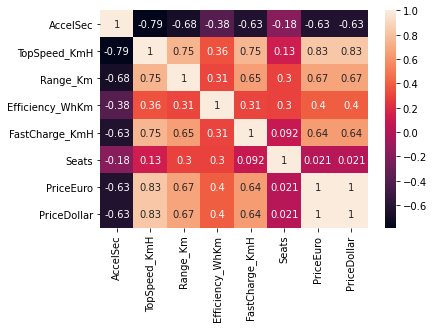

In [315]:
sns.heatmap(data.corr(), annot=True)

In [316]:
data_mul = data.T @ data

In [317]:
data_mul = data_mul.apply(lambda x: x/x.max())
data_mul

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Seats,PriceEuro,PriceDollar
AccelSec,0.557734,0.433903,0.417606,0.454010,0.415806,0.455833,0.388094,0.388094
TopSpeed_KmH,0.584845,0.658869,0.656547,0.624101,0.666251,0.613456,0.682153,0.682153
Range_Km,0.454949,0.530658,0.559153,0.501017,0.544753,0.496596,0.559666,0.559666
Efficiency_WhKm,0.980524,1.000000,0.993227,1.000000,1.000000,0.975122,1.000000,1.000000
FastCharge_KmH,0.625953,0.744116,0.752755,0.697040,0.811559,0.681342,0.787376,0.787376
Seats,1.000000,0.998457,1.000000,0.990513,0.992906,1.000000,0.972387,0.972387
PriceEuro,0.318102,0.414824,0.421077,0.379522,0.428707,0.363308,0.494827,0.494827
PriceDollar,0.318102,0.414824,0.421077,0.379522,0.428707,0.363308,0.494827,0.494827


### Singular Value Decomposition

In [318]:
u, s, vh = np.linalg.svd(data_mul)
s

array([5.47253699e+00, 3.01564414e-01, 6.48384084e-02, 4.07361253e-02,
       2.25812729e-02, 1.21204276e-02, 8.27008007e-03, 1.30572136e-34])

### Condition number

In [319]:
s.max()/s.min()

4.19119819471754e+34

In [320]:
np.linalg.det(data_mul)

0.0

**Condition number is unnaceptable and matrix is not invertible.** Two things we do not want.